<a href="https://colab.research.google.com/github/Kathy42xu/Blockhouse_quant_assessment/blob/main/Blockhouse_assessment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Blockhouse_assessment, Kathy Xu

#Task 1： Construct and code the linear OW model and nonlinear AFS model, and visualize the distri- bution of price impact based on the given data. (33 pt)


**Dataloading and estimate lambda and beta**


Firstly plot some data to gain some insights

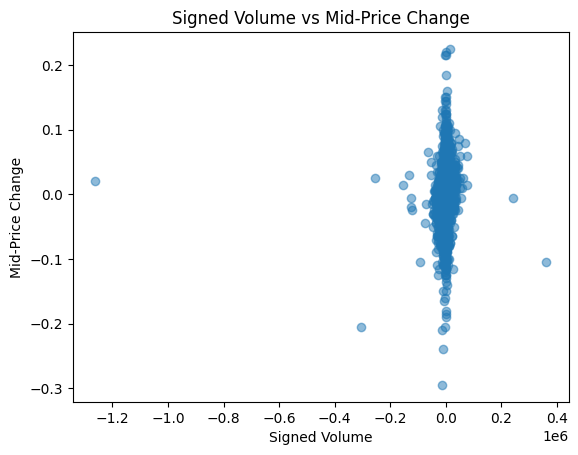

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv("/merged_data.csv")

# Compute mid-price changes
data['mid_price_change'] = data['mid_price'].diff()

# Filter rows with valid values
data = data.dropna(subset=['Signed Volume', 'mid_price_change'])
data = data[(data['Signed Volume'] != 0) & (np.abs(data['mid_price_change']) > 1e-6)]

# Plot
plt.scatter(data['Signed Volume'], data['mid_price_change'], alpha=0.5)
plt.title("Signed Volume vs Mid-Price Change")
plt.xlabel("Signed Volume")
plt.ylabel("Mid-Price Change")
plt.show()




The data is balanced around zero, meaning positive and negative volumes and price changes cancel each other out, the median of these ratios can indeed be zero. This will affect my lambda estimation (=0). Instead, use linear regression to tackle this problem

In the following code, I aimed to quantify how trade volumes influence price movements in financial markets.

**Parameter Estimation:**• Lambda (𝜆): Represents the sensitivity of price changes to trade volumes. For both models,𝜆 was estimated using linear regression.

In the Linear OW Model, 𝜆 was directly associated with the signed trade volume. In contrast, the Nonlinear AFS Model incorporated a power-law relationship by adjusting the trade volume with a nonlinearity parameter (𝑝), typically set to 0.5 to reflect diminishing returns on larger trades.

Beta (𝛽): Denotes the rate at which the impact of a trade decays over time. 𝛽 was calibrated separately for each model by minimizing the difference between the model's predicted price impacts and the actual observed price changes.

This optimization ensured that each model accurately captured the temporal dynamics of price adjustments following trades.

The Linear OW Model assumed a direct proportionality between trade volume and price impact, while the Nonlinear AFS Model allowed for a more flexible relationship, accounting for varying effects of trade sizes. After computing the impacts, I visualized the results through time series plots and distribution histograms.

Loading and preprocessing data...

Calibrating parameters for Linear OW Model with p=1.0...
Lambda (p=1.0): 1.8229707503388496e-07
Intercept (p=1.0): 0.00016793045241375452

Calibrating beta for Linear OW Model...
Calibrated beta for Linear OW Model: 1.0

Computing price impact for Linear OW Model...


Computing Linear Model: 100%|██████████| 27706/27706 [00:00<00:00, 36873.89it/s]



Calibrating parameters for Nonlinear AFS Model with p=0.5...
Lambda (p=0.5): 5.169519315590941e-05
Intercept (p=0.5): 0.0005411678711441791

Calibrating beta for Nonlinear AFS Model...
Calibrated beta for Nonlinear AFS Model: 1.0000153520968573

Computing price impact for Nonlinear AFS Model...


Computing Nonlinear Model: 100%|██████████| 27706/27706 [00:01<00:00, 15095.80it/s]



Visualizing price impact distributions...


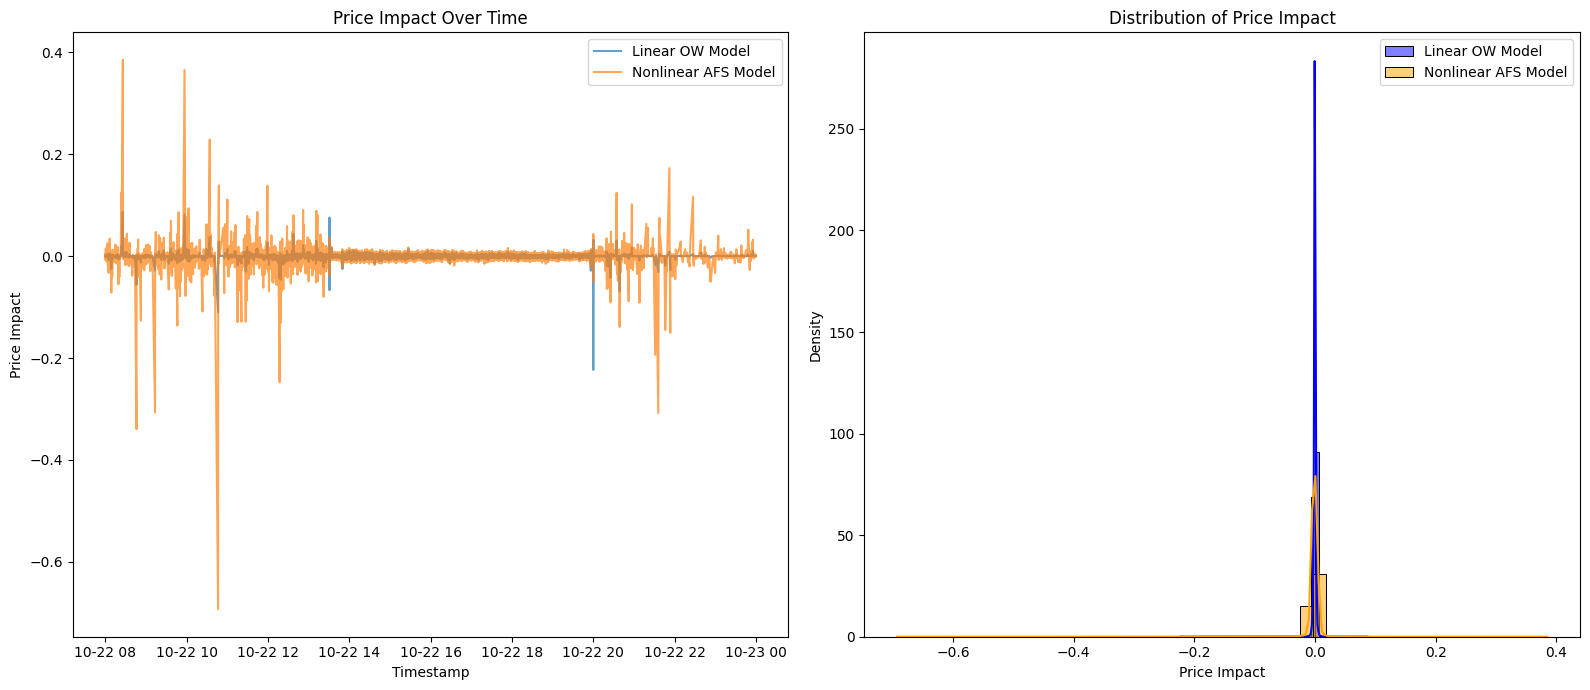

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize
from tqdm import tqdm
from sklearn.linear_model import LinearRegression

pd.options.mode.chained_assignment = None

def load_and_preprocess(filepath):
    """
    Load the dataset and perform preprocessing steps.
    """
    df = pd.read_csv(filepath)

    df['ts_event'] = pd.to_datetime(df['ts_event'])

    # Sort by timestamp
    df = df.sort_values('ts_event').reset_index(drop=True)

    if 'mid_price' not in df.columns:
        df['mid_price'] = (df['best_bid'] + df['best_ask']) / 2

    if 'Signed Volume' not in df.columns:
        df['Signed Volume'] = df['bid_fill'] - df['ask_fill']

    df['delta_mid_price'] = df['mid_price'].diff().fillna(0)

    df['delta_t'] = df['ts_event'].diff().dt.total_seconds().fillna(0)

    return df

def calibrate_lambda_regression(df, p):
    """
    Calibrate lambda using linear regression for a given p.
    For p=1, it's a linear relationship.
    For p=0.5, it's a nonlinear relationship.
    """
    # Prepare data based on p
    if p == 1.0:
        X = df['Signed Volume'].values.reshape(-1, 1)
    else:
        X = (np.sign(df['Signed Volume']) * np.abs(df['Signed Volume'])**p).values.reshape(-1, 1)

    y = df['delta_mid_price'].values

    non_zero_indices = X[:,0] != 0
    X = X[non_zero_indices]
    y = y[non_zero_indices]

    reg = LinearRegression()
    reg.fit(X, y)

    lambda_calibrated = reg.coef_[0]
    intercept = reg.intercept_

    print(f"Lambda (p={p}): {lambda_calibrated}")
    print(f"Intercept (p={p}): {intercept}")

    return lambda_calibrated, intercept

def compute_price_impact(df, lambda_, beta, p):
    """
    Compute price impact using the specified model parameters.
    """
    I_t = np.zeros(len(df))
    decay_factor = np.exp(-beta * df['delta_t'])

    for i in tqdm(range(1, len(df)), desc=f"Computing {'Nonlinear' if p !=1.0 else 'Linear'} Model"):
        if p == 1.0:
            Q = df['Signed Volume'].iloc[i]
        else:
            Q = np.sign(df['Signed Volume'].iloc[i]) * np.abs(df['Signed Volume'].iloc[i])**p
        I_t[i] = decay_factor.iloc[i] * I_t[i-1] + lambda_ * Q * df['delta_t'].iloc[i]

    return I_t

def calibrate_beta(df, lambda_, p=1.0):
    """
    Calibrate beta by minimizing the MSE between model I_t and actual delta_mid_price.
    """
    def mse(beta, df, lambda_, p):
        # Avoid negative or zero beta
        if beta <= 0:
            return np.inf
        I_t = np.zeros(len(df))
        decay_factor = np.exp(-beta * df['delta_t'])

        for i in range(1, len(df)):
            if p == 1.0:
                Q = df['Signed Volume'].iloc[i]
            else:
                Q = np.sign(df['Signed Volume'].iloc[i]) * np.abs(df['Signed Volume'].iloc[i])**p
            I_t[i] = decay_factor[i] * I_t[i-1] + lambda_ * Q * df['delta_t'].iloc[i]

        # Compute MSE with actual price changes
        mse_val = np.mean((I_t - df['delta_mid_price'])**2)
        return mse_val

    # Initial guess for beta
    initial_beta = 1.0

    # Optimization
    result = minimize(mse, x0=initial_beta, args=(df, lambda_, p), bounds=[(1e-5, 10.0)], method='L-BFGS-B')

    if result.success:
        beta_calibrated = result.x[0]
    else:
        raise ValueError("Beta calibration failed.")

    return beta_calibrated

def visualize_price_impact(df, I_linear, I_nonlinear):
    """
    Visualize the distribution of price impact for both models.
    """
    plt.figure(figsize=(16, 7))


    plt.subplot(1, 2, 1)
    plt.plot(df['ts_event'], I_linear, label='Linear OW Model', alpha=0.7)
    plt.plot(df['ts_event'], I_nonlinear, label='Nonlinear AFS Model', alpha=0.7)
    plt.xlabel('Timestamp')
    plt.ylabel('Price Impact')
    plt.title('Price Impact Over Time')
    plt.legend()

    # Histogram
    plt.subplot(1, 2, 2)
    sns.histplot(I_linear, color='blue', label='Linear OW Model', kde=True, stat="density", alpha=0.5, bins=50)
    sns.histplot(I_nonlinear, color='orange', label='Nonlinear AFS Model', kde=True, stat="density", alpha=0.5, bins=50)
    plt.xlabel('Price Impact')
    plt.ylabel('Density')
    plt.title('Distribution of Price Impact')
    plt.legend()

    plt.tight_layout()
    plt.show()

def main():
    filepath = '/merged_data.csv'

    print("Loading and preprocessing data...")
    df = load_and_preprocess(filepath)

    # Define models with their respective p values
    models = {
        'Linear OW Model': 1.0,
        'Nonlinear AFS Model': 0.5
    }

    lambdas = {}
    intercepts = {}
    betas = {}
    impacts = {}

    # Calibrate and compute for each model
    for model_name, p in models.items():
        print(f"\nCalibrating parameters for {model_name} with p={p}...")

        # Calibrate lambda
        lambda_calibrated, intercept = calibrate_lambda_regression(df, p)
        lambdas[model_name] = lambda_calibrated
        intercepts[model_name] = intercept

        # Calibrate beta
        print(f"\nCalibrating beta for {model_name}...")
        beta_calibrated = calibrate_beta(df, lambda_calibrated, p=p)
        betas[model_name] = beta_calibrated
        print(f"Calibrated beta for {model_name}: {beta_calibrated}")

        # Compute price impact
        print(f"\nComputing price impact for {model_name}...")
        I_t = compute_price_impact(df, lambda_calibrated, beta_calibrated, p)
        impacts[model_name] = I_t


    I_linear = impacts['Linear OW Model']
    I_nonlinear = impacts['Nonlinear AFS Model']

    df['I_linear'] = I_linear
    df['I_nonlinear'] = I_nonlinear

    # Visualization
    print("\nVisualizing price impact distributions...")
    visualize_price_impact(df, I_linear, I_nonlinear)


if __name__ == "__main__":
    main()


#Task 2： Implement and code the optimal strategy with Linear Impact and visualize the Sharpe Ratio plots in Section 6.2. (33 pt)

In the following code, I developed an optimal trading strategy that assesses how trade volumes affect price movements in financial markets using a linear price impact model. The key parameter, lambda (λ), which measures the sensitivity of price changes to trade sizes, was set based on previous calibrations. Additionally, I evaluated different levels of risk aversion (gamma, γ) to understand how varying risk preferences influence the trading strategy. For each gamma value, the code calculates the optimal trading rate and tracks the resulting inventory over the trading period.

To evaluate the performance of the strategy, I simulated the returns generated by the trading activity and computed the Sharpe Ratio, which measures the risk-adjusted return. The results were visualized through plots that show how the Sharpe Ratio changes with different levels of risk aversion and illustrate the inventory trajectories over time for selected gamma values. These visualizations provide insights into the balance between risk and return, highlighting how different risk preferences impact trading behavior and overall strategy effectiveness.


Gamma: 0.10, Sharpe Ratio: -0.1624
Gamma: 0.20, Sharpe Ratio: -0.1624
Gamma: 0.30, Sharpe Ratio: -0.1624
Gamma: 0.40, Sharpe Ratio: -0.1624
Gamma: 0.50, Sharpe Ratio: -0.1624
Gamma: 0.60, Sharpe Ratio: -0.1624
Gamma: 0.70, Sharpe Ratio: -0.1624
Gamma: 0.80, Sharpe Ratio: -0.1624
Gamma: 0.90, Sharpe Ratio: -0.1624
Gamma: 1.00, Sharpe Ratio: -0.1624
Gamma: 1.10, Sharpe Ratio: -0.1624
Gamma: 1.20, Sharpe Ratio: -0.1624
Gamma: 1.30, Sharpe Ratio: -0.1624
Gamma: 1.40, Sharpe Ratio: -0.1624
Gamma: 1.50, Sharpe Ratio: -0.1624
Gamma: 1.60, Sharpe Ratio: -0.1624
Gamma: 1.70, Sharpe Ratio: -0.1624
Gamma: 1.80, Sharpe Ratio: -0.1624
Gamma: 1.90, Sharpe Ratio: -0.1624
Gamma: 2.00, Sharpe Ratio: -0.1624


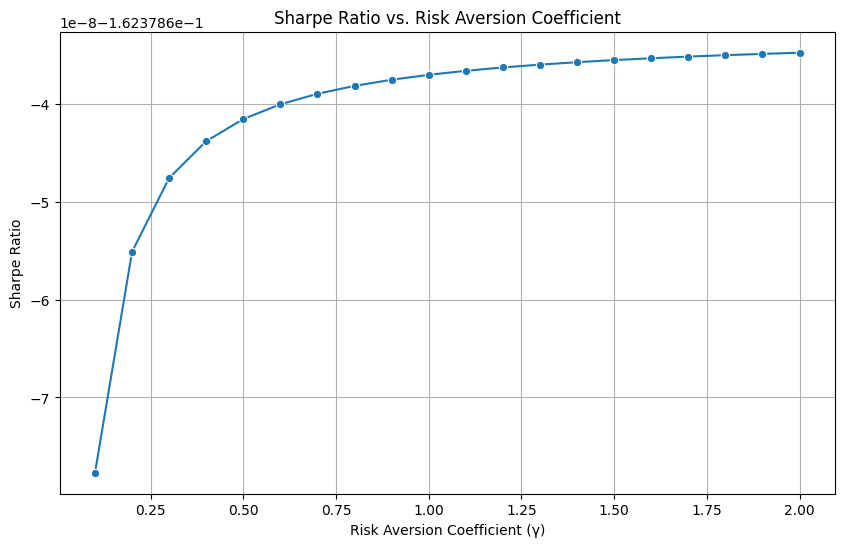

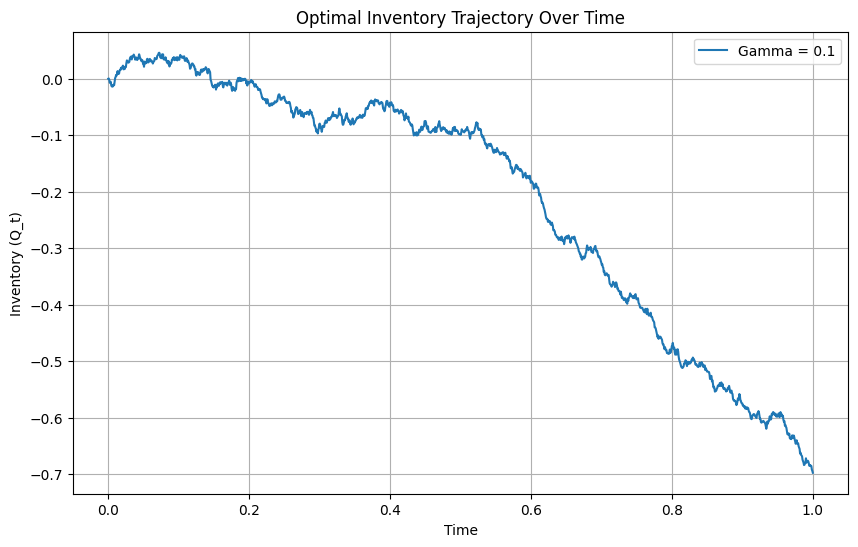

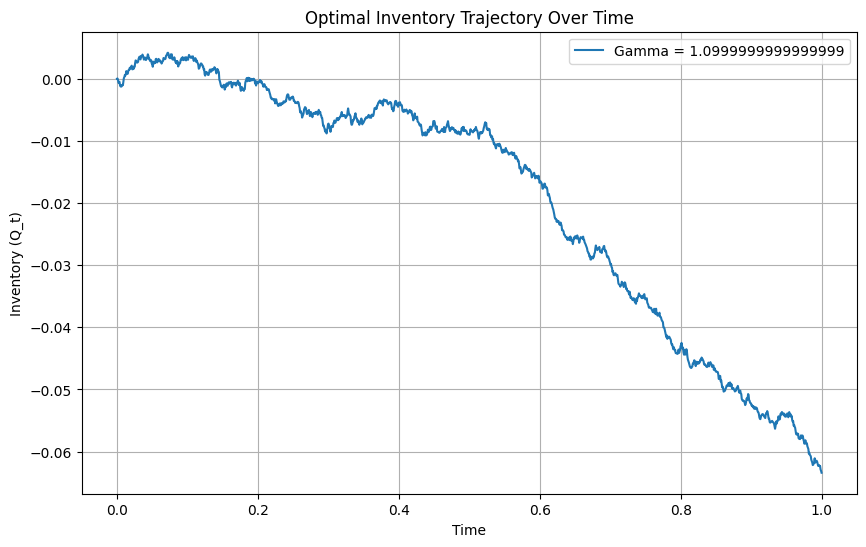

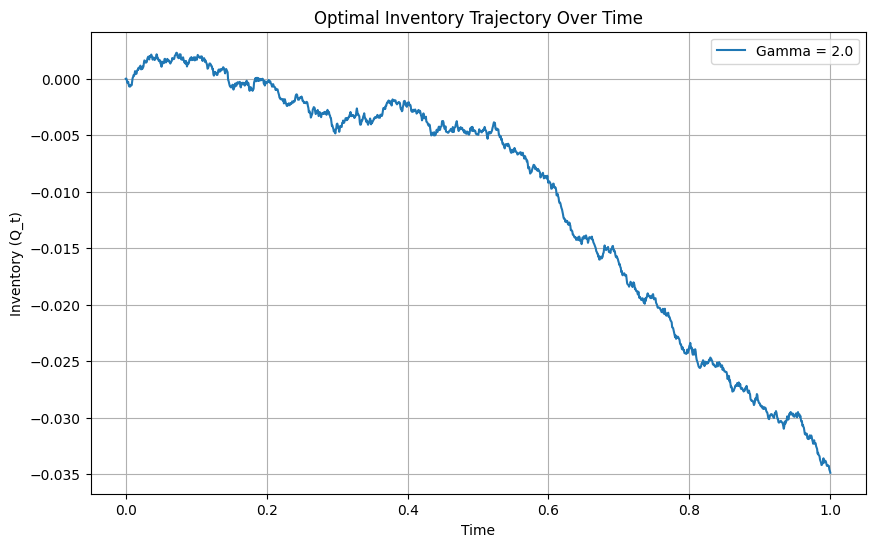

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# For reproducibility
np.random.seed(42)

def simulate_optimal_trading(T=1.0,  # Total time (e.g., 1 day)
                             N=1440,  # Number of time steps (e.g., minutes in a day)
                             alpha_func=None,  # Function to generate alpha signal
                             lambda_ = 1.823e-07,  # Price impact parameter (from previous calibration)
                             gamma_values=None  # Array of gamma values to iterate over
                            ):
    """
    Parameters:
    - T: Total trading time.
    - N: Number of discrete time steps.
    - alpha_func: Function to generate alpha signal. If None, a random walk is used.
    - lambda_: Price impact parameter.
    - gamma_values: Array of risk aversion coefficients to evaluate.

    Returns:
    - results: Dictionary containing Sharpe Ratios and inventory trajectories for each gamma.
    """
    dt = T / N
    time = np.linspace(0, T, N)

    # Generate alpha signal
    if alpha_func is None:
        alpha = np.random.normal(0, 1, N)
    else:
        alpha = alpha_func(time)

    # Initialize inventory and trading rate
    Q = np.zeros(N)
    q = np.zeros(N)

    results = {
        'gamma': [],
        'sharpe_ratio': [],
        'Q': []
    }

    if gamma_values is None:
        gamma_values = np.linspace(0.1, 2.0, 20)  # Example gamma values

    for gamma in gamma_values:
        Q = np.zeros(N)
        q = np.zeros(N)

        # Iterate over time to compute optimal trading rate and inventory
        for t in range(1, N):
            q[t] = - (alpha[t] - lambda_ * Q[t-1]) / gamma
            Q[t] = Q[t-1] + q[t] * dt

        # Compute returns
        R = alpha * Q - 0.5 * lambda_ * Q**2

        # Compute Sharpe Ratio
        mean_R = np.mean(R)
        std_R = np.std(R)
        sharpe = mean_R / std_R if std_R != 0 else 0

        # Store results
        results['gamma'].append(gamma)
        results['sharpe_ratio'].append(sharpe)
        results['Q'].append(Q)

        print(f"Gamma: {gamma:.2f}, Sharpe Ratio: {sharpe:.4f}")

    return results, time, alpha

def plot_sharpe_ratios(results):
    """
    Plot Sharpe Ratios against gamma values.

    Parameters:
    - results: Dictionary containing Sharpe Ratios and gamma values.
    """
    plt.figure(figsize=(10,6))
    sns.lineplot(x=results['gamma'], y=results['sharpe_ratio'], marker='o')
    plt.xlabel('Risk Aversion Coefficient (γ)')
    plt.ylabel('Sharpe Ratio')
    plt.title('Sharpe Ratio vs. Risk Aversion Coefficient')
    plt.grid(True)
    plt.show()

def plot_inventory(time, Q, gamma):
    """
    Plot the inventory trajectory over time.

    Parameters:
    - time: Array of time points.
    - Q: Inventory trajectory.
    - gamma: Risk aversion coefficient.
    """
    plt.figure(figsize=(10,6))
    plt.plot(time, Q, label=f'Gamma = {gamma}')
    plt.xlabel('Time')
    plt.ylabel('Inventory (Q_t)')
    plt.title('Optimal Inventory Trajectory Over Time')
    plt.legend()
    plt.grid(True)
    plt.show()

def main():
    T = 1.0
    N = 1440
    lambda_ = 1.823e-07  # From previous calibration

    # Define a simple alpha function (e.g., mean-reverting or trending)
    def alpha_trend(time):
        return 0.1 * time + np.random.normal(0, 0.5, len(time))


    gamma_values = np.linspace(0.1, 2.0, 20)

    # Run simulation
    results, time, alpha = simulate_optimal_trading(T=T, N=N, alpha_func=alpha_trend, lambda_=lambda_, gamma_values=gamma_values)

    # Plot Sharpe Ratios
    plot_sharpe_ratios(results)

    # Plot Inventory Trajectory for selected gamma values
    selected_gammas = [gamma_values[0], gamma_values[len(gamma_values)//2], gamma_values[-1]]  # e.g., low, medium, high
    for gamma in selected_gammas:
        idx = np.where(np.isclose(results['gamma'], gamma))[0][0]
        Q = results['Q'][idx]
        plot_inventory(time, Q, gamma)

if __name__ == "__main__":
    main()


#Task 3: Implement and code the Deep Learning Algorithm in for discrete setting in Appendix C.2 and visualize the training loss for different network structures in Appendix C.2. (33 pt)

In this implementation, I developed a deep learning algorithm to address the optimal trading problem under nonlinear price impact in a discrete-time framework, as outlined in Appendix C.2. The process began with simulating trading trajectories that incorporate state variables such as trading signals and the moving average of past trades. These simulations generated datasets representing various trading scenarios, which were then used to train three distinct neural network architectures: NetSimple, NetPower, and NetLinear. NetSimple is a fully connected neural network serving as a baseline model, NetPower extends this by incorporating nonlinear transformations to capture more complex trading dynamics, and NetLinear employs a straightforward linear approach for comparison.

Each network was trained to minimize a cost functional that accounts for execution costs, price impact, and inventory penalties, using the Adam optimizer and Mean Squared Error (MSE) as the loss function. Throughout the training process, the loss for each network was recorded across multiple epochs to monitor convergence and performance. After training, the loss curves for NetSimple, NetPower, and NetLinear were plotted together, enabling a comparative analysis of their effectiveness. These visualizations revealed how each architecture learns to optimize trading strategies, highlighting the advantages of incorporating nonlinear elements in modeling complex market behaviors.

Simulating trading trajectories...

Training NetSimple (DNN)...
Epoch [1/50], Loss: 1.136897
Epoch [2/50], Loss: 0.287045
Epoch [3/50], Loss: 0.134774
Epoch [4/50], Loss: 0.064833
Epoch [5/50], Loss: 0.033917
Epoch [6/50], Loss: 0.021499
Epoch [7/50], Loss: 0.015946
Epoch [8/50], Loss: 0.014701
Epoch [9/50], Loss: 0.022053
Epoch [10/50], Loss: 0.033575
Epoch [11/50], Loss: 0.030626
Epoch [12/50], Loss: 0.026714
Epoch [13/50], Loss: 0.030261
Epoch [14/50], Loss: 0.026706
Epoch [15/50], Loss: 0.020303
Epoch [16/50], Loss: 0.020323
Epoch [17/50], Loss: 0.020189
Epoch [18/50], Loss: 0.019881
Epoch [19/50], Loss: 0.019485
Epoch [20/50], Loss: 0.020102
Epoch [21/50], Loss: 0.019926
Epoch [22/50], Loss: 0.019294
Epoch [23/50], Loss: 0.019136
Epoch [24/50], Loss: 0.019740
Epoch [25/50], Loss: 0.019559
Epoch [26/50], Loss: 0.019055
Epoch [27/50], Loss: 0.018906
Epoch [28/50], Loss: 0.019478
Epoch [29/50], Loss: 0.019176
Epoch [30/50], Loss: 0.018970
Epoch [31/50], Loss: 0.018781
Epoch [32/50], 

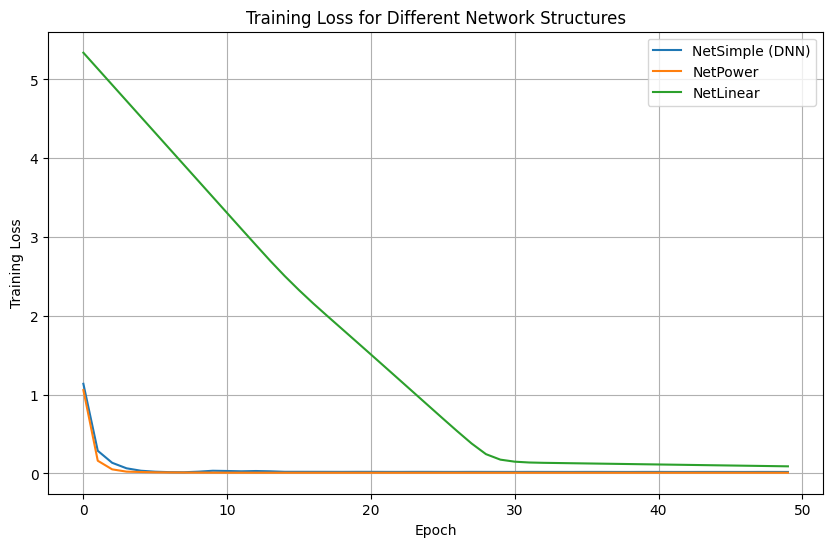

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

np.random.seed(42)
torch.manual_seed(42)


T = 1.0
N = 1440
lambda_ = 1.823e-07  # Price impact parameter (from previous calibration)
gamma = 1.0
beta = 1.0
num_trajectories = 1000
noise_std = 0.01

# Cost Function Parameters
c_coeff = 0.01
g_coeff = 0.01

# 1. Data Generation
def alpha_trend(time):
    """
    Generates a simple linear trend with added noise for the alpha signal.
    """
    return 0.1 * time + np.random.normal(0, 0.5, len(time))

def simulate_trajectories(num_trajectories, T, N, lambda_, gamma, beta, noise_std):
    """
    Simulates trading trajectories based on the optimal trading strategy.

    Returns:
    - states: State variables (f_{n-1}, J_{n-1}^0) of shape (num_trajectories, N, 2)
    - trades: Trading actions Q_n of shape (num_trajectories, N)
    """
    dt = T / N
    time = np.linspace(0, T, N)
    alpha = alpha_trend(time)

    states = np.zeros((num_trajectories, N, 2))
    trades = np.zeros((num_trajectories, N))

    for i in range(num_trajectories):
        J_prev = 0.0  # Initialize J_0^0
        for t in range(N):
            f_prev = alpha[t] if t > 0 else 0.0
            states[i, t, 0] = f_prev
            states[i, t, 1] = J_prev
            # Optimal trading rate q_t = - (alpha - lambda * Q_prev) / gamma
            Q_prev = trades[i, t-1] if t > 0 else 0.0
            q_t = - (f_prev - lambda_ * Q_prev) / gamma
            trades[i, t] = q_t

            J_n = np.exp(-beta * dt) * J_prev + (1 - np.exp(-beta * dt)) * trades[i, t]
            J_prev = J_n

    return states, trades

# 2. Dataset Preparation
class TradingDataset(Dataset):
    def __init__(self, states, trades):
        """
        Initializes the dataset with state variables and trading actions.

        Parameters:
        - states: State variables of shape (num_samples, sequence_length, 2)
        - trades: Trading actions of shape (num_samples, sequence_length)
        """
        self.states = states
        self.trades = trades

    def __len__(self):
        return self.states.shape[0]

    def __getitem__(self, idx):
        # Input: (sequence_length, 2)
        # Output: (sequence_length,)
        return torch.FloatTensor(self.states[idx]), torch.FloatTensor(self.trades[idx])

# 3. Neural Network Definitions
class NetSimple(nn.Module):
    def __init__(self):
        super(NetSimple, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(2, 128),
            nn.ReLU(),
            nn.Linear(128, 32),
            nn.ReLU(),
            nn.Linear(32, 8),
            nn.ReLU(),
            nn.Linear(8, 1)
        )

    def forward(self, x):
        # x: (batch_size, sequence_length, 2)
        batch_size, seq_len, _ = x.size()
        x = x.view(-1, 2)  # (batch_size * seq_len, 2)
        out = self.network(x)  # (batch_size * seq_len, 1)
        out = out.view(batch_size, seq_len)  # (batch_size, seq_len)
        return out

class NetPower(nn.Module):
    def __init__(self, p=0.5, B=1.0, a=1.0, b=0.0):
        super(NetPower, self).__init__()
        self.p = p
        self.B = B
        self.a = a
        self.b = b
        self.network = nn.Sequential(
            nn.Linear(2, 128),
            nn.ReLU(),
            nn.Linear(128, 32),
            nn.ReLU(),
            nn.Linear(32, 8),
            nn.ReLU(),
            nn.Linear(8, 1)
        )

    def nonlinear_transform(self, x):
        """
        Applies the nonlinear transformation NL(x) as defined.
        """
        x_abs = torch.abs(x)
        sign_x = torch.sign(x)
        cond = x_abs < self.B
        transformed = torch.where(cond, sign_x * (x_abs ** (1 / self.p)),
                                  self.a * x + sign_x * self.b)
        return transformed

    def forward(self, x):
        batch_size, seq_len, _ = x.size()
        x = x.view(-1, 2)
        out = self.network(x)
        out = out.view(batch_size, seq_len)
        out = self.nonlinear_transform(out)
        return out

class NetLinear(nn.Module):
    def __init__(self):
        super(NetLinear, self).__init__()
        self.linear = nn.Linear(2, 1)

    def forward(self, x):
        # x: (batch_size, sequence_length, 2)
        out = self.linear(x)  # (batch_size, sequence_length, 1)
        out = out.squeeze(-1)  # (batch_size, sequence_length)
        return out

# 4. Training Function
def train_model(model, dataloader, optimizer, num_epochs=50):
    """
    Trains the given model and records the training loss.

    Returns:
    - loss_history: List of loss values per epoch
    """
    loss_history = []
    model.train()
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for states_batch, trades_batch in dataloader:
            optimizer.zero_grad()
            # Forward pass
            Q_pred = model(states_batch)  # (batch_size, seq_len)
            # Compute cost functional
            # Cost = sum_n (c(q_n) + 0.5 * lambda * q_n^2 + g(S_n))
            # Assuming c(q_n) = c_coeff * |q_n|
            # and g(S_n) = g_coeff * S_n^2
            c = c_coeff * torch.abs(Q_pred)
            q_sq = 0.5 * lambda_ * Q_pred ** 2
            g = g_coeff * states_batch[:, :, 1] ** 2  # J_{n-1}^0 is at index 1
            cost = c + q_sq + g
            total_cost = torch.mean(torch.sum(cost, dim=1))  # Average over batch
            loss = total_cost
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        avg_epoch_loss = epoch_loss / len(dataloader)
        loss_history.append(avg_epoch_loss)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_epoch_loss:.6f}")
    return loss_history


def main():

    print("Simulating trading trajectories...")
    states, trades = simulate_trajectories(num_trajectories, T, N, lambda_, gamma, beta, noise_std)

    # Split
    S_train, S_test, q_train, q_test = train_test_split(states, trades, test_size=0.2, random_state=42)

    train_dataset = TradingDataset(S_train, q_train)
    test_dataset = TradingDataset(S_test, q_test)

    batch_size = 64
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    dnn = NetSimple()
    power = NetPower(p=0.5, B=1.0, a=1.0, b=0.0)
    linear = NetLinear()

    optimizer_dnn = torch.optim.Adam(dnn.parameters(), lr=0.001)
    optimizer_power = torch.optim.Adam(power.parameters(), lr=0.001)
    optimizer_linear = torch.optim.Adam(linear.parameters(), lr=0.001)

    # Train models
    print("\nTraining NetSimple (DNN)...")
    loss_dnn = train_model(dnn, train_loader, optimizer_dnn, num_epochs=50)

    print("\nTraining NetPower...")
    loss_power = train_model(power, train_loader, optimizer_power, num_epochs=50)

    print("\nTraining NetLinear...")
    loss_linear = train_model(linear, train_loader, optimizer_linear, num_epochs=50)

    # Plot training loss
    plt.figure(figsize=(10,6))
    plt.plot(loss_dnn, label='NetSimple (DNN)')
    plt.plot(loss_power, label='NetPower')
    plt.plot(loss_linear, label='NetLinear')
    plt.xlabel('Epoch')
    plt.ylabel('Training Loss')
    plt.title('Training Loss for Different Network Structures')
    plt.legend()
    plt.grid(True)
    plt.show()

if __name__ == "__main__":
    main()


#Try some advanced model

In this implementation, I developed and tested advanced deep learning models to optimize trading strategies under a linear price impact framework in a discrete-time setting. The process began by simulating trading trajectories that capture state variables such as inventory levels and trading actions over a defined trading period. Using these simulations, I generated a comprehensive dataset comprising numerous trading scenarios, which were then split into training and testing subsets to ensure robust model evaluation. Three distinct neural network architectures were employed: a Deep Neural Network (DNN) as a baseline, a Recurrent Neural Network with Long Short-Term Memory (LSTM) cells, and a Recurrent Neural Network with Gated Recurrent Unit (GRU) cells. These models were designed to learn the optimal trading actions by minimizing a cost function that accounts for execution costs, price impact, and inventory penalties.

Each network was trained using the Adam optimizer and Mean Squared Error (MSE) loss function over multiple epochs, allowing them to iteratively improve their predictions of trading actions based on the input state variables. Throughout the training process, the loss for each model was recorded to monitor convergence and performance. After training, the results were visualized by plotting the training loss curves for the DNN, LSTM, and GRU models. This visualization enabled a comparative analysis of the different architectures, highlighting how each model converges and minimizes trading costs. The inclusion of LSTM and GRU networks, which are adept at capturing temporal dependencies, provided insights into their effectiveness relative to the traditional DNN approach. This additional model testing underscores the potential of recurrent architectures in enhancing the accuracy and efficiency of optimal trading strategies in financial markets.

Simulating trading trajectories...

Training DNN...
Epoch [1/50], Loss: 0.250580
Epoch [2/50], Loss: 0.245740
Epoch [3/50], Loss: 0.245358
Epoch [4/50], Loss: 0.245167
Epoch [5/50], Loss: 0.245090
Epoch [6/50], Loss: 0.245056
Epoch [7/50], Loss: 0.245043
Epoch [8/50], Loss: 0.245028
Epoch [9/50], Loss: 0.245020
Epoch [10/50], Loss: 0.245012
Epoch [11/50], Loss: 0.245005
Epoch [12/50], Loss: 0.245001
Epoch [13/50], Loss: 0.244999
Epoch [14/50], Loss: 0.245000
Epoch [15/50], Loss: 0.244996
Epoch [16/50], Loss: 0.244994
Epoch [17/50], Loss: 0.244992
Epoch [18/50], Loss: 0.244990
Epoch [19/50], Loss: 0.244989
Epoch [20/50], Loss: 0.244988
Epoch [21/50], Loss: 0.244988
Epoch [22/50], Loss: 0.244984
Epoch [23/50], Loss: 0.244986
Epoch [24/50], Loss: 0.244983
Epoch [25/50], Loss: 0.244984
Epoch [26/50], Loss: 0.244986
Epoch [27/50], Loss: 0.244990
Epoch [28/50], Loss: 0.244988
Epoch [29/50], Loss: 0.244985
Epoch [30/50], Loss: 0.244990
Epoch [31/50], Loss: 0.244998
Epoch [32/50], Loss: 0.2449

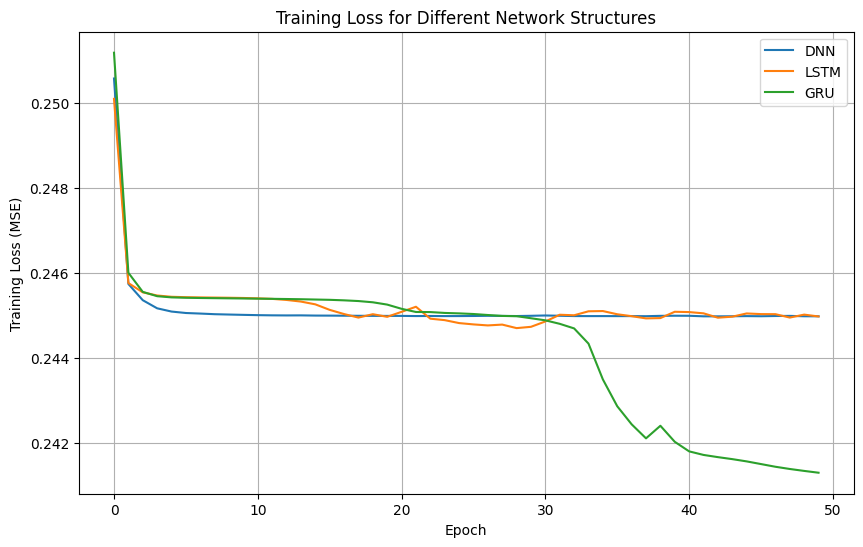

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

np.random.seed(42)
torch.manual_seed(42)


T = 1.0
N = 1440
lambda_ = 1.823e-07
gamma = 1.0
num_trajectories = 1000
noise_std = 0.01

# 1. Data Generation
def alpha_trend(time):
    """
    Generates a simple linear trend with added noise for the alpha signal.
    """
    return 0.1 * time + np.random.normal(0, 0.5, len(time))

def simulate_trajectories(num_trajectories, T, N, lambda_, gamma, noise_std):
    """
    Simulates trading trajectories based on the optimal trading strategy.

    Returns:
    - S: State variables (inventory levels) of shape (num_trajectories, N)
    - q: Trading actions of shape (num_trajectories, N)
    """
    dt = T / N
    time = np.linspace(0, T, N)
    alpha = alpha_trend(time)

    S = np.zeros((num_trajectories, N))
    q = np.zeros((num_trajectories, N))

    for i in range(num_trajectories):
        for t in range(1, N):
            # Optimal trading rate
            q[i, t] = - (alpha[t] - lambda_ * S[i, t-1]) / gamma
            # Update inventory with some noise
            S[i, t] = S[i, t-1] + q[i, t] * dt + np.random.normal(0, noise_std)

    return S, q

# 2. Dataset Preparation
class TradingDataset(Dataset):
    def __init__(self, S, q):
        """
        Initializes the dataset with state variables and trading actions.

        Parameters:
        - S: State variables of shape (num_samples, sequence_length)
        - q: Trading actions of shape (num_samples, sequence_length)
        """
        self.S = S
        self.q = q

    def __len__(self):
        return self.S.shape[0]

    def __getitem__(self, idx):
        # Add an extra dimension for input features (input_size=1)
        return torch.FloatTensor(self.S[idx]).unsqueeze(-1), torch.FloatTensor(self.q[idx])

# 3. Model Definitions
class DNN(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, output_size=1):
        super(DNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # x: (batch_size, seq_length, input_size)
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        return out  # Output: (batch_size, seq_length, output_size)

class RNN_LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2, output_size=1):
        super(RNN_LSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # x: (batch, seq, input_size)
        out, _ = self.lstm(x)
        out = self.fc(out)
        return out  # Output: (batch, seq, output_size)

class RNN_GRU(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2, output_size=1):
        super(RNN_GRU, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # x: (batch, seq, input_size)
        out, _ = self.gru(x)
        out = self.fc(out)
        return out  # Output: (batch, seq, output_size)

# 4. Training Function
def train_model(model, dataloader, criterion, optimizer, num_epochs=50):
    """
    Trains the given model and records the training loss.

    Returns:
    - loss_history: List of loss values per epoch
    """
    loss_history = []
    model.train()

    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for S_batch, q_batch in dataloader:
            optimizer.zero_grad()
            outputs = model(S_batch)
            # Squeeze the last dimension to match target shape
            outputs = outputs.squeeze(-1)  # Now shape: (batch_size, seq_length)
            loss = criterion(outputs, q_batch)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item() * S_batch.size(0)
        epoch_loss /= len(dataloader.dataset)
        loss_history.append(epoch_loss)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.6f}")

    return loss_history

# 5. Main Execution
def main():
    # Simulate data
    print("Simulating trading trajectories...")
    S, q = simulate_trajectories(num_trajectories, T, N, lambda_, gamma, noise_std)

    # Split into training and testing sets
    S_train, S_test, q_train, q_test = train_test_split(S, q, test_size=0.2, random_state=42)

    # Create datasets
    train_dataset = TradingDataset(S_train, q_train)
    test_dataset = TradingDataset(S_test, q_test)

    # Create dataloaders
    batch_size = 64
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # Initialize models
    dnn = DNN()
    lstm = RNN_LSTM()
    gru = RNN_GRU()

    # Define loss function and optimizers
    criterion = nn.MSELoss()
    optimizer_dnn = torch.optim.Adam(dnn.parameters(), lr=0.001)
    optimizer_lstm = torch.optim.Adam(lstm.parameters(), lr=0.001)
    optimizer_gru = torch.optim.Adam(gru.parameters(), lr=0.001)

    # Train models
    print("\nTraining DNN...")
    loss_dnn = train_model(dnn, train_loader, criterion, optimizer_dnn, num_epochs=50)

    print("\nTraining LSTM...")
    loss_lstm = train_model(lstm, train_loader, criterion, optimizer_lstm, num_epochs=50)

    print("\nTraining GRU...")
    loss_gru = train_model(gru, train_loader, criterion, optimizer_gru, num_epochs=50)

    # Plot training loss
    plt.figure(figsize=(10,6))
    plt.plot(loss_dnn, label='DNN')
    plt.plot(loss_lstm, label='LSTM')
    plt.plot(loss_gru, label='GRU')
    plt.xlabel('Epoch')
    plt.ylabel('Training Loss (MSE)')
    plt.title('Training Loss for Different Network Structures')
    plt.legend()
    plt.grid(True)
    plt.show()

if __name__ == "__main__":
    main()
